In [1]:
import numpy as np
import scipy
import scipy.spatial
from scipy.spatial.distance import squareform,pdist,cdist
import matplotlib.pyplot as plt
from scipy.io import mmread

from sklearn.manifold import TSNE
from joblib import Parallel, delayed

from timeit import default_timer as timer

from PIL import Image


In [ ]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath('..'))


# Experimnet

### understand how to load data 

In [2]:
import os

data_dir= ''
arr = os.listdir(data_dir )


In [3]:
modality= np.array([int(filename[1]) for filename in arr])
time  = np.array([int(filename[3:9]) for filename in arr])
time_vals= np.sort(np.unique(time))

###  load data

In [4]:
n=5000
orig_sin_im_size= np.array([60, 80])
orig_im_size = orig_sin_im_size+0
orig_im_size[1]*=2


sub_rate =4
sing_im_size = np.prod(orig_sin_im_size)
im_size= np.prod(orig_im_size)
x= np.zeros((n, im_size))


for i,cur_time in enumerate(time_vals[:n]):
    inds= np.where(np.array(time)==cur_time)[0]
    
    inds= inds[np.argsort(modality[inds])]
    
    curr_im= np.zeros(orig_im_size)
    for t in range(2):
        im = Image.open(data_dir+'/'+arr[inds[t]]).convert('L')        
        curr_im[:,t*orig_sin_im_size[1]:(t+1)*orig_sin_im_size[1]]= np.array(im)[::sub_rate,::sub_rate]/255.
        
    x[i,:]=curr_im.flatten()


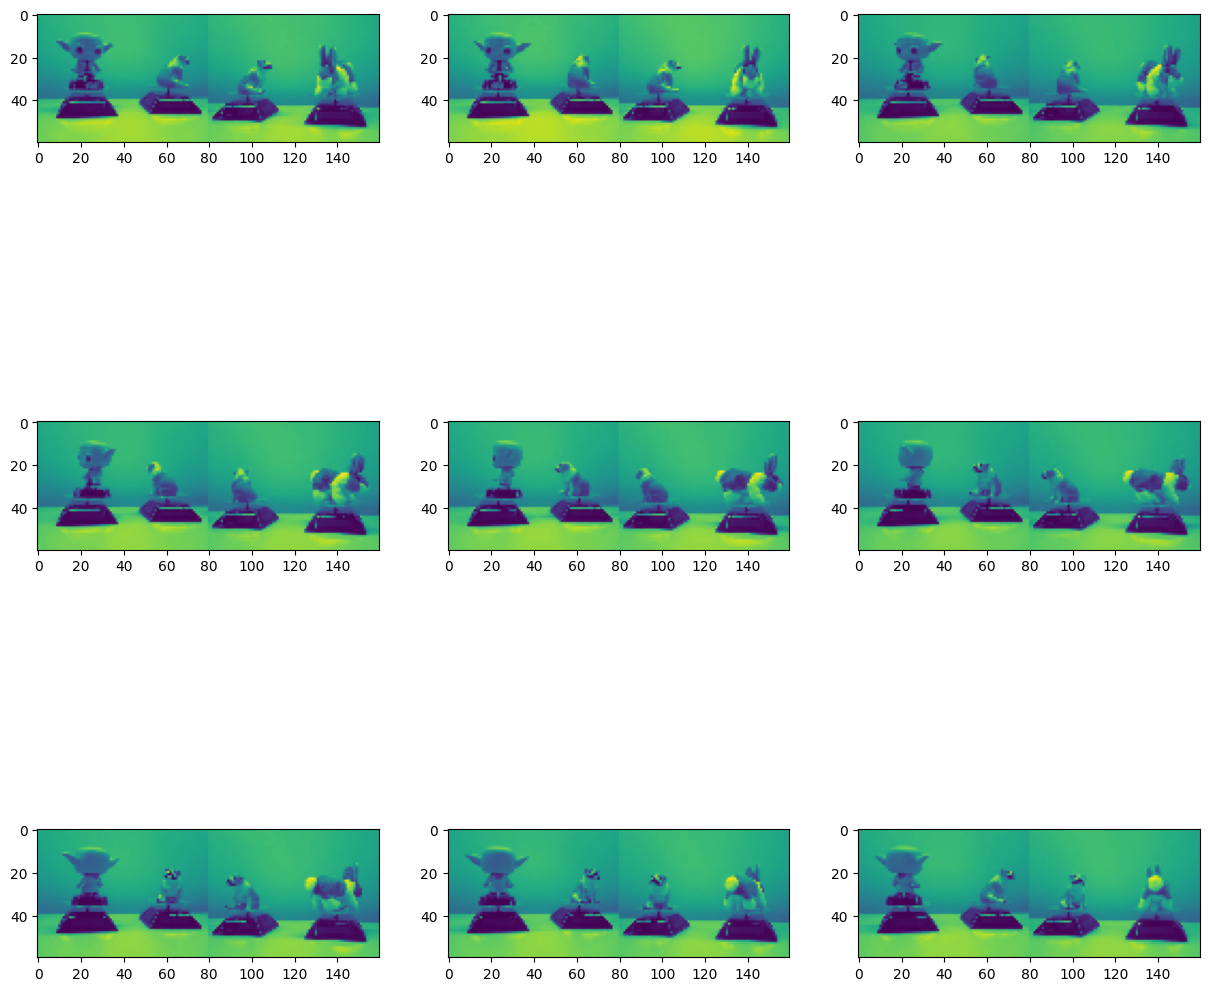

In [5]:
amount_figs=9

f,ax= plt.subplots(3,3,figsize=(15,15))
for i in range(amount_figs):
    ax.flatten()[i].imshow(x[i,:].reshape(orig_im_size))
    


# Extract colors
( Extract the colors manually by applying Diffusion Maps based on the figurines' pixels)

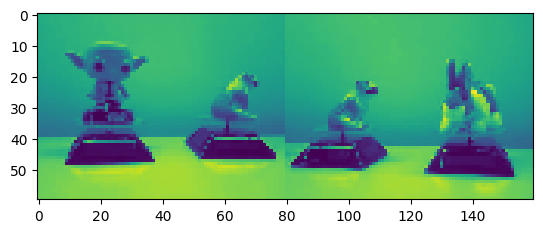

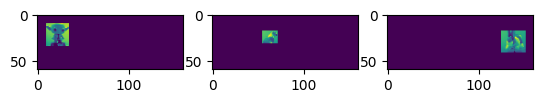

In [6]:
plt.figure()
plt.imshow(x[0,:].reshape(orig_im_size))

mask1 = x[0,:].reshape(orig_im_size)*0.
mask1[10:35,10:35]=1.
mask1 = mask1.flatten()

mask2 = x[0,:].reshape(orig_im_size)*0.
mask2[18:32,55:72]=1.
mask2 = mask2.flatten()

mask3 = x[0,:].reshape(orig_im_size)*0.
mask3[18:42,125:152]=1.
mask3 = mask3.flatten()

f,ax = plt.subplots(1,3)
ax[0].imshow((x[0,:]*mask1).reshape(orig_im_size))
ax[1].imshow((x[0,:]*mask2).reshape(orig_im_size))
ax[2].imshow((x[0,:]*mask3).reshape(orig_im_size))


In [7]:
from sklearn.neighbors import NearestNeighbors

# Computes the diffusion map embedding of the given dataset.
#
# Diffusion maps are a spectral dimensionality reduction technique that captures 
# the intrinsic geometry of the data using a diffusion process defined over the data graph.
#
# Parameters:
#   data : np.ndarray of shape (N, D)
#       Input data matrix with N samples and D features.
#
#   n_neighbors : int (default=10)
#       Number of nearest neighbors used to estimate the Gaussian kernel bandwidth (sigma).
#
#   embedding_dim : int (default=10)
#       Number of diffusion components (eigenvectors/eigenvalues) to retain in the embedding.
#
#   alpha : float (default=1.0)
#       Normalization parameter for the kernel matrix:
#           - alpha = 0 → no normalization
#           - alpha = 1 → standard normalization (removes sampling density influence)
#           - 0 < alpha < 1 interpolates between the two
#
# Returns:
#   embedding : np.ndarray of shape (N, embedding_dims)
#       The diffusion map embedding of the input data. Each row is a low-dimensional
#       representation of a sample based on the leading diffusion components.

def diffusion_maps(data, n_neighbors=10, embedding_dim= 10 ,alpha=1.):
    
    dist= scipy.spatial.distance.cdist(data,data)**2
    
    sigma = np.max(np.partition(dist,n_neighbors,axis=1)[:,n_neighbors])
    W = np.exp(-dist**2 / (2 * sigma**2))   
    D = np.sum(W, axis=1,keepdims=True)
    if alpha>0.:
        W= (1/D**alpha)*W*(1/(D.T)**(alpha))
        D = np.sum(W, axis=1,keepdims=True)
    M = 1/D * W
    
    eigenvalues, eigenvectors = np.linalg.eig(M)
    
    idx = np.argsort(eigenvalues)[::-1][:embedding_dim]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    embedding = np.real(eigenvectors *eigenvalues)

    return embedding

In [8]:
yoda_dmaps = diffusion_maps(x[:,np.where(mask1>0)[0]])
dog_dmaps  = diffusion_maps(x[:,np.where(mask2>0)[0]])
bunny_dmaps  = diffusion_maps(x[:,np.where(mask3>0)[0]])

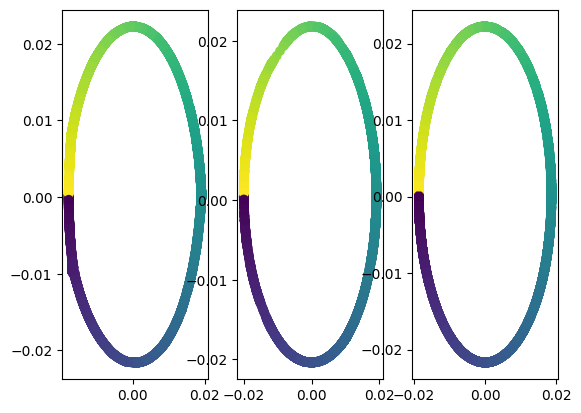

In [10]:
# Extract the angle of each figurine from the first two coordinates of Diffusion Maps
dog_mid= (np.max(dog_dmaps,axis=0)+np.min(dog_dmaps,axis=0))/2
yoda_mid= (np.max(yoda_dmaps,axis=0)+np.min(yoda_dmaps,axis=0))/2
bunny_mid= (np.max(bunny_dmaps,axis=0)+np.min(bunny_dmaps,axis=0))/2

c_yoda= np.arctan2(yoda_dmaps[:,2]-yoda_mid[2],yoda_dmaps[:,1]-yoda_mid[1])
c_dog= np.arctan2(dog_dmaps[:,2]-dog_mid[2],dog_dmaps[:,1]-dog_mid[1])
c_bunny= np.arctan2(bunny_dmaps[:,2]-bunny_mid[2],bunny_dmaps[:,1]-bunny_mid[1])

f,ax= plt.subplots(1,3)
ax[0].scatter(yoda_dmaps[:,1],yoda_dmaps[:,2],c=c_yoda)
ax[1].scatter(dog_dmaps[:,1],dog_dmaps[:,2],c=c_dog)
ax[2].scatter(bunny_dmaps[:,1],bunny_dmaps[:,2],c=c_bunny)

### Run experiment 

In [11]:
from FP import *

In [ ]:
# Run our algorithm using 2 feature partitions
K=2

fp = FP(  perplexity=10, K=K)
fp.fit(x, verbose=True,simulations=100)

In [20]:
print(fp.get_optimization_summary()['objective_value'])

np.float64(1.5442816589546862)